<a href="https://colab.research.google.com/github/CAP4770-group9-project/final-project/blob/notebook%2Fkmeans/k-means-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering for Stock Portfolio Diversification

Diversification is a very important step in stock portfolio creation. Picking several stocks rather than just one helps to reduce some of the inherent risk with investing. However, to reap the full benefits of diversification one not only has to pick more than one stock but also ensure that the behaviour of the stocks are not correlated.

This measure of "differentiality" in stock return and variance behavior can be calculated using K means clustering. The stock price data over diffrent periods of time can be put into the clustering algorithm with the goal of clustering the stock based on diffrent behavior. Stocks from these clusters then can be chosen in order to create a well-diversified portfolio.

## Data preprocessing

Now we can import the S&P500 data into Colab

In [78]:
#change directory to where the data is located 
!pwd
%cd drive/My Drive/cap4770-project

/content/drive/My Drive/cap4770-project
[Errno 2] No such file or directory: 'drive/My Drive/cap4770-project'
/content/drive/My Drive/cap4770-project


In [79]:
import pandas as pd
import time

#use timer to get process times
start_time = time.time()

#read csv
data = pd.read_csv("SP_DAILY_2000-2020.csv")
print("read data --- %s seconds ---" % (time.time() - start_time))

availableStocks = data['Symbol'].unique()
print("Number of stocks in the dataset: ", len(availableStocks))
print(data)

read data --- 1.3307902812957764 seconds ---
Number of stocks in the dataset:  503
        Symbol        Date    Open   Close     High     Low    Volume
0          MMM  2020-03-26  131.79  135.98  136.355  130.61   5476351
1          MMM  2020-03-25  133.15  131.54  134.690  126.80   7732467
2          MMM  2020-03-24  122.29  132.72  133.450  121.00   9304832
3          MMM  2020-03-23  128.16  117.87  128.400  114.04   7920348
4          MMM  2020-03-20  138.07  124.89  139.240  122.71   9582251
...        ...         ...     ...     ...      ...     ...       ...
2250258    ZTS  2013-02-07   31.00   32.00   32.730   31.00   3800800
2250259    ZTS  2013-02-06   30.98   31.03   31.430   30.75   2126100
2250260    ZTS  2013-02-05   31.25   31.04   31.980   30.85   5013200
2250261    ZTS  2013-02-04   31.09   31.02   31.990   30.76   7695400
2250262    ZTS  2013-02-01   31.50   31.01   31.740   30.47  66789100

[2250263 rows x 7 columns]


Now we can extract the training data from the dataset

In [80]:
#create DateTime column
stocksData = data

stocksData['DateTime'] = pd.to_datetime(stocksData.apply(lambda row: row['Date'], axis=1))

print(stocksData)

        Symbol        Date    Open  ...     Low    Volume   DateTime
0          MMM  2020-03-26  131.79  ...  130.61   5476351 2020-03-26
1          MMM  2020-03-25  133.15  ...  126.80   7732467 2020-03-25
2          MMM  2020-03-24  122.29  ...  121.00   9304832 2020-03-24
3          MMM  2020-03-23  128.16  ...  114.04   7920348 2020-03-23
4          MMM  2020-03-20  138.07  ...  122.71   9582251 2020-03-20
...        ...         ...     ...  ...     ...       ...        ...
2250258    ZTS  2013-02-07   31.00  ...   31.00   3800800 2013-02-07
2250259    ZTS  2013-02-06   30.98  ...   30.75   2126100 2013-02-06
2250260    ZTS  2013-02-05   31.25  ...   30.85   5013200 2013-02-05
2250261    ZTS  2013-02-04   31.09  ...   30.76   7695400 2013-02-04
2250262    ZTS  2013-02-01   31.50  ...   30.47  66789100 2013-02-01

[2250263 rows x 8 columns]


In [81]:
#get full training data set
trainData = stocksData[(stocksData['DateTime'] > '2010-03-26') & (stocksData['DateTime'] < '2015-03-26')]

#get training data set for 2015
trainData2015 = stocksData[(stocksData['DateTime'] > '2014-03-26') & (stocksData['DateTime'] < '2015-03-26')]
print(trainData2015)

        Symbol        Date    Open   Close     High     Low   Volume   DateTime
1260       MMM  2015-03-25  166.24  162.70  166.520  162.66  2540422 2015-03-25
1261       MMM  2015-03-24  165.58  166.32  167.650  165.53  2090967 2015-03-24
1262       MMM  2015-03-23  166.83  166.13  166.905  165.83  2155702 2015-03-23
1263       MMM  2015-03-20  166.09  166.49  167.134  165.39  4371778 2015-03-20
1264       MMM  2015-03-19  166.16  165.66  166.210  164.85  1953456 2015-03-19
...        ...         ...     ...     ...      ...     ...      ...        ...
2249969    ZTS  2014-04-02   29.28   29.62   29.700   29.14  2341200 2014-04-02
2249970    ZTS  2014-04-01   28.97   29.35   29.390   28.97  3658000 2014-04-01
2249971    ZTS  2014-03-31   29.07   28.94   29.140   28.66  8689200 2014-03-31
2249972    ZTS  2014-03-28   29.46   29.01   29.510   28.91  6398900 2014-03-28
2249973    ZTS  2014-03-27   29.21   29.30   29.395   29.08  2984200 2014-03-27

[120564 rows x 8 columns]


We can perform an initial visualization of the data by plotting

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
grouped_day_stocks = []
grouped_day = []

#plot all data
#plt.figure()
#for i in range(0, len(availableStocks)):
#  grouped_day_stocks.append(stocksData[stocksData['Symbol'] == availableStocks[i]])
#  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

In [0]:
#group day for all training data
grouped_day_stocks = []
grouped_day = []

for i in range(0, len(availableStocks)):
  grouped_day_stocks.append(trainData[trainData['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))

#print("grouped day stocks")
#print(grouped_day_stocks, "\n")



In [0]:
#print(grouped_day_stocks)

In [0]:
#plot only training data
#plt.figure()
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

For this 1 year sample of the training data, we can calculate the annualized average returns (based on price at close), annualized average volatility (based on price at close), the average intraday price variation (pct change between daily high and low), average diffrence in price between open and close and annualized trading volume from the data. 

The intraday price variation and diffrence between open and close will be used as additional measures of volatility and hopefully will add richness to the resutls of the k-means analysis

In [0]:
#group day for 2015 data
grouped_day_stocks = []
grouped_day = []

for i in range(0, len(availableStocks)):
  grouped_day_stocks.append(trainData2015[trainData2015['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))

  

In [88]:
print(len(grouped_day_stocks))

503


###Plotting

ValueError: ignored

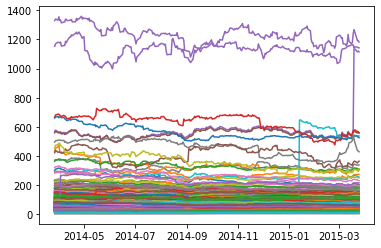

In [89]:
#plot only training data 2015
plt.figure()
for j in range(0, len(availableStocks)):
  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
plt.show()

In [90]:
annualized_data = pd.DataFrame(index=availableStocks, columns=['Returns', 'Volatility','Volume', 'HighLowDiff', 'OpenCloseDiff'])

#aggregate annualized stock data used in cluserting analysis into dataframe
for i in range(0, len(grouped_day_stocks)):
  
  annualized_data.loc[availableStocks[i]]['Returns'] = grouped_day_stocks[i]['Close'].pct_change().mean() * 252
  annualized_data.loc[availableStocks[i]]['Volatility'] = grouped_day_stocks[i]['Close'].pct_change().std() * 252
  annualized_data.loc[availableStocks[i]]['Volume'] = grouped_day_stocks[i]['Volume'].mean() * 252
  annualized_data.loc[availableStocks[i]]['HighLowDiff'] = ((grouped_day_stocks[i]['High'] - grouped_day_stocks[i]['Low']) / grouped_day_stocks[i]['Low']).mean()
  annualized_data.loc[availableStocks[i]]['OpenCloseDiff'] = ((grouped_day_stocks[i]['Close'] - grouped_day_stocks[i]['Open']) / grouped_day_stocks[i]['Open']).mean()  

print("Annualized data for each stock in S&P500 calculated form 2014 to 2015:")
print(annualized_data)

print("Min/Max statistics: \n")
print("Max returns: ")
print(annualized_data[annualized_data['Returns'] == max(annualized_data['Returns'])], "\n")
print("Min returns: ")
print(annualized_data[annualized_data['Returns'] == min(annualized_data['Returns'])], "\n")

print("Max volatility: ")
print(annualized_data[annualized_data['Volatility'] == max(annualized_data['Volatility'],key=abs)], "\n")
print("Min volatility: ")
print(annualized_data[annualized_data['Volatility'] == min(annualized_data['Volatility'],key=abs)], "\n")

print("Max volume: ")
print(annualized_data[annualized_data['Volume'] == max(annualized_data['Volume'],key=abs)], "\n")
print("Min volume: ")
print(annualized_data[annualized_data['Volume'] == min(annualized_data['Volume'],key=abs)], "\n")

print("Max HighLowDiff: ")
print(annualized_data[annualized_data['HighLowDiff'] == max(annualized_data['HighLowDiff'],key=abs)], "\n")
print("Min HighLowDiff: ")
print(annualized_data[annualized_data['HighLowDiff'] == min(annualized_data['HighLowDiff'],key=abs)], "\n")

print("Max OpenCloseDiff: ")
print(annualized_data[annualized_data['OpenCloseDiff'] == max(annualized_data['OpenCloseDiff'],key=abs)], "\n")
print("Min OpenCloseDiff: ")
print(annualized_data[annualized_data['OpenCloseDiff'] == min(annualized_data['OpenCloseDiff'],key=abs)], "\n")

#

Annualized data for each stock in S&P500 calculated form 2014 to 2015:
        Returns Volatility       Volume HighLowDiff OpenCloseDiff
MMM   -0.192913    2.39916  5.90628e+08   0.0120139   0.000711119
ABT   -0.179184    2.56219  1.33327e+09   0.0146175   0.000502251
ABBV -0.0819894    4.43024  2.60313e+09   0.0221427   0.000568866
ABMD  -0.913676    6.76712  9.48344e+07   0.0307168    0.00185815
ACN  -0.0988941    2.73051  6.90803e+08   0.0140433   0.000706258
...         ...        ...          ...         ...           ...
YUM  -0.0580078    3.26328  7.98818e+08   0.0157174   0.000238743
ZBRA  -0.213887    4.39027  1.31668e+08   0.0230687    0.00090546
ZBH   -0.195326    3.44852  3.14272e+08   0.0162313  -6.55949e-05
ZION   0.143904    3.47235   6.4069e+08   0.0205199  -0.000154421
ZTS   -0.439027    3.25018  9.31993e+08   0.0175066    0.00123164

[503 rows x 5 columns]
Min/Max statistics: 

Max returns: 
      Returns Volatility       Volume HighLowDiff OpenCloseDiff
AAPL  5.50024

For now we will run the K means using only 3 attributes, the mean returns, variance, and volume

In [91]:
#Concatenating the returns and variances and volume into a single data-frame
ret_var_vol = annualized_data.drop(['HighLowDiff','OpenCloseDiff'], axis=1)
print(ret_var_vol)

        Returns Volatility       Volume
MMM   -0.192913    2.39916  5.90628e+08
ABT   -0.179184    2.56219  1.33327e+09
ABBV -0.0819894    4.43024  2.60313e+09
ABMD  -0.913676    6.76712  9.48344e+07
ACN  -0.0988941    2.73051  6.90803e+08
...         ...        ...          ...
YUM  -0.0580078    3.26328  7.98818e+08
ZBRA  -0.213887    4.39027  1.31668e+08
ZBH   -0.195326    3.44852  3.14272e+08
ZION   0.143904    3.47235   6.4069e+08
ZTS   -0.439027    3.25018  9.31993e+08

[503 rows x 3 columns]


In [0]:
#taken from: https://towardsdatascience.com/machine-learning-for-stock-clustering-using-k-means-algorithm-126bc1ace4e1
#https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

#format the data as a numpy array to feed into the K-Means algorithm
#X = np.asarray([np.asarray(ret_var_vol['Returns']),np.asarray(ret_var_vol['Volatility']),np.asarray(ret_var_vol['Volume'])]).T
X = ret_var_vol.dropna().values

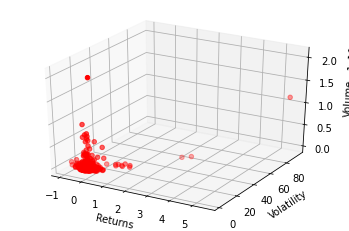

In [93]:
#first plot data to spot outliers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)
z = list(ret_var_vol['Volume'].dropna().values)
#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()

In [0]:
#identify the volatility outlier, drop, then graph again
# volatility outliers 'AAPL', 'V', 'HBI'
#outlier = ret_var_vol['Volatility'] == max(ret_var_vol['Volatility'],key=abs)
#outlierIndex = ret_var_vol[outlier].index
#print(outlierIndex, "\n")

outlierIndex = ['AAPL','V','HBI']
ret_var_vol.drop(outlierIndex, inplace =True)

In [0]:
#code to drop volume outliers
#volume outlier 'BAC'
#outlier = ret_var_vol['Volume'] == max(ret_var_vol['Volume'],key=abs)
#outlierIndex = ret_var_vol[outlier].index
#print(outlierIndex, "\n")

outlierIndex = 'BAC'
ret_var_vol.drop(outlierIndex, inplace =True)

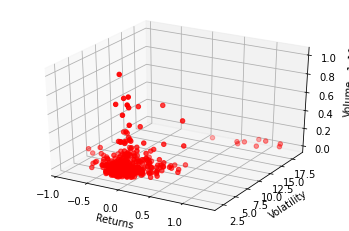

In [96]:
#regraph after outliers are dropped

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)
z = list(ret_var_vol['Volume'].dropna().values)
#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()

Text(0.5, 1.0, 'Elbow curve')

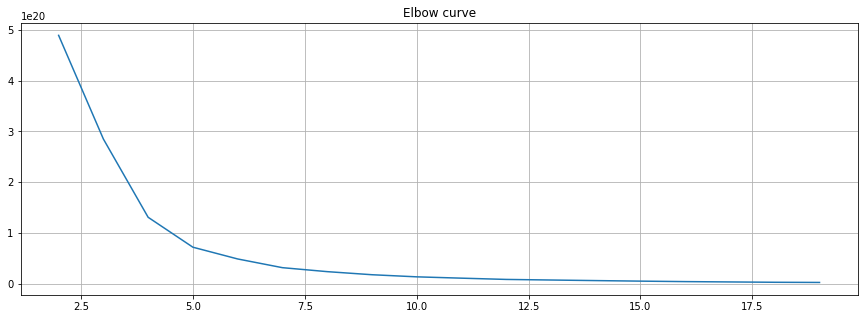

In [97]:
#generate elbow curve
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

##Clustering Analysis

In [0]:
#recreate data to feed into the algorithm
ret_var_vol.dropna()
X = np.asarray([np.asarray(ret_var_vol['Returns']),np.asarray(ret_var_vol['Volatility']),np.asarray(ret_var_vol['Volume'])]).T

In [99]:
import  pylab as pl

kmeans = KMeans(n_clusters = 5).fit(X)
centroids = kmeans.cluster_centers_
pl.scatter(X[:,0],X[:,1],X[:,2], c = kmeans.labels_, cmap ="rainbow")
pl.show()

ValueError: ignored

In [0]:

# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(data,5)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'oy',
     data[idx==2,0],data[idx==2,1],'or',
     data[idx==3,0],data[idx==3,1],'og',
     data[idx==4,0],data[idx==4,1],'om')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()